# Extract Specific Regions from GenBank
Extract only those sequences that have all three regions annotated: E, 5′UTR, 3′UTR.

### Import required libraries

In [1]:
from Bio import SeqIO
import pandas as pd
import re

### Setup

In [2]:
# Path to GenBank file
gb_path = "../data/indian_denv_genomes.gb"

# Store extracted data
extracted = []

### Define Extraction Logic

In [3]:
def extract_year(record):
    # Try collection_date first
    try:
        for feature in record.features:
            if feature.type == "source" and "collection_date" in feature.qualifiers:
                return re.findall(r"\d{4}", feature.qualifiers["collection_date"][0])[0]
    except:
        pass

    # Fallback: Try reference journal year
    try:
        journal = record.annotations['references'][0].journal
        return re.findall(r"\d{4}", journal)[0]
    except:
        return None

### Parse and Extract Regions

In [4]:
for record in SeqIO.parse(gb_path, "genbank"):
    accession = record.id
    year = extract_year(record)

    e_seq, utr5_seq, utr3_seq = None, None, None

    for feature in record.features:
        if feature.type == "CDS" and "gene" in feature.qualifiers and "E" in feature.qualifiers["gene"]:
            e_seq = str(feature.extract(record.seq))
        elif feature.type == "5'UTR":
            utr5_seq = str(feature.extract(record.seq))
        elif feature.type == "3'UTR":
            utr3_seq = str(feature.extract(record.seq))

    if e_seq and utr5_seq and utr3_seq:
        combined_seq = utr5_seq + e_seq + utr3_seq
        extracted.append((accession, year, combined_seq))

In [7]:
for record in SeqIO.parse(gb_path, "genbank"):
    accession = record.id
    year = extract_year(record)

    seq = record.seq
    full_length = len(seq)

    utr5_seq = str(seq[0:95])  # 5′UTR
    e_seq = str(seq[937:2406])  # E gene
    utr3_seq = str(seq[10272:full_length])  # 3′UTR

    if len(utr5_seq) > 0 and len(e_seq) > 0 and len(utr3_seq) > 0:
        combined_seq = utr5_seq + e_seq + utr3_seq
        extracted.append((accession, year, combined_seq))

### Save as CSV

In [8]:
df = pd.DataFrame(extracted, columns=["Accession", "Collection_Year", "Combined_Sequence"])
df.to_csv("../data/extracted_sequences.csv", index=False)
print(f"{len(df)} sequences with all three regions extracted and saved.")

404 sequences with all three regions extracted and saved.


### Data Quality Check

In [9]:
df.head(5)

,Accession,Collection_Year,Combined_Sequence
0,PV554916.1,2024,GACAAAGACAGATTCTTTGAGGAAGCTAAGCTTAACGTAGTTCTAA...
1,PV554917.1,2024,GACAAAGACAGATTCTTTGAGGAAGCTAAGCTTAACGTAGTTCTAA...
2,PV554918.1,2024,CCGACAAAGACAGATTCTTTGAGGAAGCTAAGCTTAACGTAGTTCT...
3,PV554919.1,2024,GACAAGAACAGTTTCGACTCGGAAGCTTGCTTAACGTAGTGCTAAC...
4,PV554920.1,2024,GACAAAGACAGATTCTTTGAGGAAGCTAAGCTTAACGTAGTTCTAA...


count     404.000000
mean     1921.334158
std        90.222360
min      1577.000000
25%      1861.750000
50%      1949.000000
75%      1998.250000
max      2056.000000
Name: Length, dtype: float64


<Axes: >

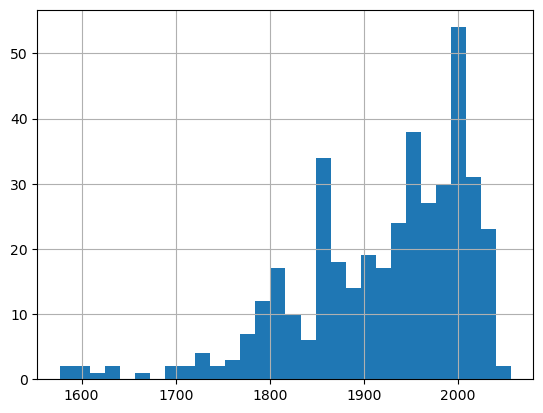

In [10]:
df["Length"] = df["Combined_Sequence"].apply(len)
print(df["Length"].describe())
df["Length"].hist(bins=30)

## Conclusion
Extracted dataset is clean and ready for alignment with environmental data.